# Geocoding slcs, etc. 

This notebook uses uavsar_pytools to geocode the uavsar data. 

In [3]:
# from uavsar_pytools.georeference import geolocate_uavsar
from pathlib import Path
import sys
import os
import numpy as np
import rioxarray as rxa

scripts_dir = (os.path.dirname(os.getcwd()) + '/scripts/')
sys.path.append(scripts_dir)

from plotting import plot_tifs_grid 
from coherence import calc_coherence_unweighted 

/Users/julo9057/anaconda3/envs/snowex_uavsar_coherence/lib/python3.13/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [4]:
print(os.getcwd())
slc_dir = "/Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/snowex_uavsar_coherence/data/snowex_lowman/slcs_raw/"
data_dir = "/Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/snowex_uavsar_coherence/data/snowex_lowman/slcs_geocoded/"
in_dir = Path(slc_dir)
slcs_05208 = sorted(list(in_dir.glob('*05208*.slc')))
anns_05208 = sorted(list(in_dir.glob('*05208*.ann')))
slcs_23205 = sorted(list(in_dir.glob('*23205*.slc')))
anns_23205 = sorted(list(in_dir.glob('*23205*.ann')))
llh_05208 = slc_dir + "lowman_05208_01_BU_s2_2x8.llh"
llh_23205 = slc_dir + "lowman_23205_01_BC_s2_2x8.llh"
print(slcs_05208)
print(anns_05208)

/Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/snowex_uavsar_coherence/notebooks
[PosixPath('/Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/snowex_uavsar_coherence/data/snowex_lowman/slcs_raw/lowman_05208_20002_006_200131_L090VV_01_BU_s2_2x8.slc'), PosixPath('/Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/snowex_uavsar_coherence/data/snowex_lowman/slcs_raw/lowman_05208_20007_002_200213_L090VV_01_BU_s2_2x8.slc'), PosixPath('/Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/snowex_uavsar_coherence/data/snowex_lowman/slcs_raw/lowman_05208_20011_002_200221_L090VV_01_BU_s2_2x8.slc'), PosixPath('/Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/snowex_uavsar_coherence/data/snowex_lowman/slcs_raw/lowman_05208_20016_003_200311_L090VV_01_BU_s2_2x8.slc'), PosixPath('/Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/snowex_uavsar_coherence/data/snowex_lowman/slcs_raw/lowman_05208_21009_005_210203_L0

This took 40 mins using griddata without any optimization. 
```
gridded = interpolate.griddata((lons, lats), slc, latlon_grid, method='nearest')
```
I think I can optimize by breaking out the steps, calculating the triangulations once for each flight path/section, then use that framework to interpolate all of the individual flight paths. 

Testing this from https://stackoverflow.com/questions/20915502/speedup-scipy-griddata-for-multiple-interpolations-between-two-irregular-grids


In [5]:
# Source - https://stackoverflow.com/a
# Posted by Jaime, modified by community. See post 'Timeline' for change history
# Retrieved 2025-11-17, License - CC BY-SA 3.0

import scipy.interpolate as spint
import scipy.spatial.qhull as qhull
import itertools

def interp_weights_so(xyz, uvw, d = 2):
    tri = qhull.Delaunay(xyz)
    simplex = tri.find_simplex(uvw)
    vertices = np.take(tri.simplices, simplex, axis=0)
    temp = np.take(tri.transform, simplex, axis=0)
    delta = uvw - temp[:, d]
    bary = np.einsum('njk,nk->nj', temp[:, :d, :], delta)
    return vertices, np.hstack((bary, 1 - bary.sum(axis=1, keepdims=True)))

def interpolate_so(values, vtx, wts):
    return np.einsum('nj,nj->n', np.take(values, vtx), wts)


In [6]:
from scipy import interpolate
import pandas as pd 
from uavsar_pytools.convert.tiff_conversion import read_annotation
import time 

def geolocate_griddata(dfile, ann, llh, out_dir = None, 
                       vtx = None, wts = None) : 

    if out_dir is None : 
        out_dir = os.getcwd()

    # read ann file for rows and columns 
    metadata = read_annotation(ann)
    metadata = pd.DataFrame(metadata).T
    rows, cols = metadata.loc['slc_2_2x8 rows', 'value'], \
                 metadata.loc['slc_2_2x8 columns', 'value']

    # read llh file
    # create mesh grid of lat/lon 
    lats = np.fromfile(llh, 'f4')[0::3]
    lons =  np.fromfile(llh, 'f4')[1::3]
    heights = np.fromfile(llh, 'f4')[2::3].reshape(rows, cols)


    lat_min = np.min(lats)
    lat_max = np.max(lats)
    lon_min = np.min(lons)
    lon_max = np.max(lons)
    lat_space = np.linspace(lat_min, lat_max, num=8333)
    lon_space = np.linspace(lon_min, lon_max, num=4896)
    latlon_grid = np.meshgrid(lon_space, lat_space, indexing='xy')
    print(type(latlon_grid))

    # check if datafile is slc 
    if (Path(dfile).suffix != '.slc') : 
        raise ValueError("Datafile is not a .slc file")
    # open the datafile as slc 
    slc = np.fromfile(dfile, '<c8')
    # split out the real and imaginary parts of the slc 
    # real_part = slc.real
    # imag_part = slc.imag

    print(len(lons), len(lats))
    print(slc.shape)
    # print(latlon_grid)

    # calculate the interpolation weights
    if (vtx is None) and (wts is None) : 
        start = time.perf_counter()
        vtx, wts = interp_weights_so(np.column_stack([lons, lats]), latlon_grid)
        end = time.perf_counter()
        print(f"Calculated interpolation weights in {end - start:.2f} seconds")
    elif (vtx is not None) and (wts is not None) : 
        print("Using pre-calculated interpolation weights")
    else : 
        raise ValueError("Both vtx and wts must be provided or both must be None")
    
    gridded_flat = interpolate_so(slc, vtx, wts)

    gridded = gridded_flat.reshape(latlon_grid[0].shape)

    # this works, but takes 40 mins! 
    # gridded = interpolate.griddata((lons, lats), slc, latlon_grid, method='nearest')

    # deadend, i think. 
    # gridded = interpolate.interpn((lons, lats), slc, latlon_grid, method='nearest')

    return gridded, vtx, wts



# grid = geolocate_griddata(str(slcs_05208[0]), str(anns_05208[0]), llh_05208, data_dir)



/Users/julo9057/anaconda3/envs/snowex_uavsar_coherence/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
grid_interpn, vtx, wts = geolocate_griddata(str(slcs_05208[0]), str(anns_05208[0]), llh_05208, data_dir)

<class 'tuple'>
40798368 40798368
(40798368,)


/var/folders/fj/nxxmv5353nj2t68jvxn1wc4w0000gp/T/ipykernel_88912/3098682668.py:10: DeprecationWarning: Please import `Delaunay` from the `scipy.spatial` namespace; the `scipy.spatial.qhull` namespace is deprecated and will be removed in SciPy 2.0.0.
  tri = qhull.Delaunay(xyz)


[[ 0.0000000e+00-0.0000000e+00j  0.0000000e+00+0.0000000e+00j
  -3.4837076e-01-7.6169357e-02j ...  6.1171158e-04+1.4063992e-03j
  -0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j]
 [ 0.0000000e+00-0.0000000e+00j  0.0000000e+00+0.0000000e+00j
  -9.3662016e-02-1.9814420e-01j ... -7.5350574e-04+1.0418002e-03j
   0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j]
 [-0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j
  -1.1441719e-01+5.9718370e-01j ...  2.0406991e-03+6.4765896e-05j
  -0.0000000e+00+0.0000000e+00j  0.0000000e+00-0.0000000e+00j]
 ...
 [ 0.0000000e+00+0.0000000e+00j  0.0000000e+00-0.0000000e+00j
   6.9532049e-01+3.2621011e-01j ... -3.6436835e-05+1.1287527e-03j
   0.0000000e+00-0.0000000e+00j  0.0000000e+00+0.0000000e+00j]
 [ 0.0000000e+00-0.0000000e+00j -0.0000000e+00+0.0000000e+00j
   4.8741513e-01-6.7788702e-01j ...  2.8754841e-04+3.2854563e-04j
   0.0000000e+00+0.0000000e+00j  0.0000000e+00-0.0000000e+00j]
 [ 0.0000000e+00-0.0000000e+00j -0.00000

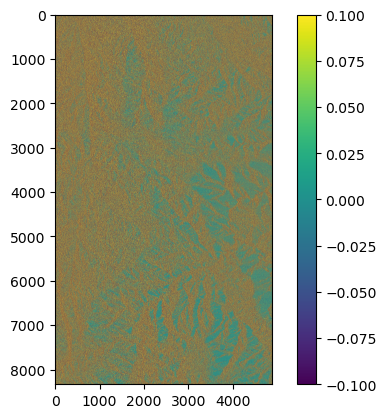

In [54]:
slc1 = np.fromfile(slcs_05208[0], '<c8').reshape(8333, 4896)

print(slc1)

plt.imshow(slc1.real, vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.show()

Latitude max: 44.19214630126953, min 43.82532501220703
Longitude max: -115.375244140625, min -115.92393493652344


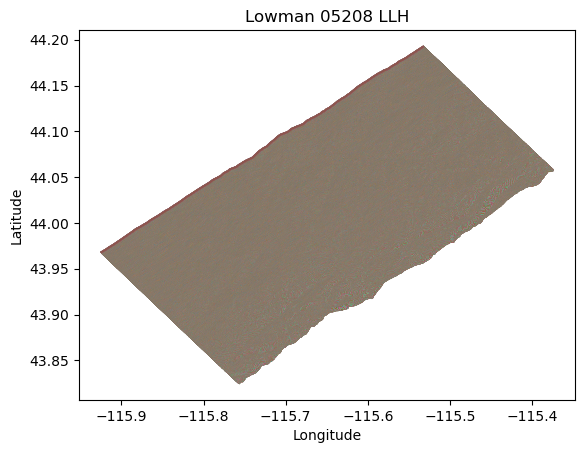

In [21]:
lats = np.fromfile(llh_05208, 'f4')[0::3].reshape(8333, 4896)
longs =  np.fromfile(llh_05208, 'f4')[1::3].reshape(8333, 4896)
heights = np.fromfile(llh_05208, 'f4')[2::3].reshape(8333, 4896)

print(f"Latitude max: {np.max(lats)}, min {np.min(lats)}")
print(f"Longitude max: {np.max(longs)}, min {np.min(longs)}")


import matplotlib.pyplot as plt

plot = plt.plot(longs, lats)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Lowman 05208 LLH')
plt.show()

#-115.78172422468924, 43.96779286703164, -115.51764754468925, 44.04996610703165

In [7]:
import rioxarray as rxa

dem_dir = '/Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/snowex_uavsar_coherence/data/snowex_lowman/snex_qsi_lidar/'
dem = rxa.open_rasterio(dem_dir + 'SNEX20_QSI_DEM_0.5M_USIDMC_20210917_20210917.tif')

print(dem.shape)
print(type(dem.values))

dem.coarsen(x=1000, y=1000, boundary='trim').mean()

(1, 16810, 15747)
<class 'numpy.ndarray'>


/Users/julo9057/anaconda3/envs/snowex_uavsar_coherence/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<xarray.DataArray (band: 1, y: 16, x: 15)> Size: 960B
array([[[     -inf,      -inf,      -inf,      -inf,      -inf,
              -inf,      -inf,      -inf,      -inf,      -inf,
              -inf,      -inf,      -inf,      -inf,      -inf],
        [     -inf,      -inf,      -inf,      -inf,      -inf,
              -inf,      -inf,      -inf,      -inf, 2153.6226,
              -inf,      -inf,      -inf,      -inf,      -inf],
        [     -inf,      -inf,      -inf,      -inf,      -inf,
              -inf,      -inf, 2242.3975, 2264.7905, 2216.035 ,
              -inf,      -inf,      -inf,      -inf,      -inf],
        [     -inf,      -inf,      -inf,      -inf,      -inf,
              -inf, 2317.6326, 2314.9446, 2278.0037, 2210.7585,
         2194.0674,      -inf,      -inf,      -inf,      -inf],
        [     -inf,      -inf,      -inf,      -inf,      -inf,
         2338.8237, 2380.736 , 2373.928 , 2303.0132, 2241.3303,
         2150.9646, 2028.2926,      -inf,      -inf,      -inf],
        [     -inf,      -inf,      -inf, 2336.0881, 2364.0266,
         2317.1926, 2330.1985, 2420.872 , 2386.03  , 2316.1787,
         2151.1213, 2013.1038,      -inf,      -inf,      -inf],
        [     -inf,      -inf, 2138.653 , 2329.2993, 2395.9595,
         2322.7244, 2244.7437, 2339.746 , 2325.5781, 2198.5369,
...
         2063.0945, 1870.6389, 1785.222 , 1766.9174, 1816.4039],
        [     -inf,      -inf,      -inf, 2221.1152, 2308.8047,
         2226.0894, 2144.7249, 1990.157 , 1971.5894, 2022.4935,
         1971.3   , 1845.097 , 1863.8302, 1901.0046,      -inf],
        [     -inf,      -inf,      -inf,      -inf, 2205.6267,
         2066.794 , 2039.3713, 2048.6658, 1881.343 , 1915.404 ,
         1875.9509, 1929.6805, 2023.3751,      -inf,      -inf],
        [     -inf,      -inf,      -inf,      -inf,      -inf,
         1940.1271, 1932.8241, 1912.7988, 1863.2683, 1801.687 ,
         1946.1508,      -inf,      -inf,      -inf,      -inf],
        [     -inf,      -inf,      -inf,      -inf,      -inf,
         1868.3823, 1828.0858, 1775.1699, 1745.3331, 1874.1595,
              -inf,      -inf,      -inf,      -inf,      -inf],
        [     -inf,      -inf,      -inf,      -inf,      -inf,
              -inf, 1692.4108, 1686.3055, 1799.1351,      -inf,
              -inf,      -inf,      -inf,      -inf,      -inf],
        [     -inf,      -inf,      -inf,      -inf,      -inf,
              -inf,      -inf, 1755.769 ,      -inf,      -inf,
              -inf,      -inf,      -inf,      -inf,      -inf]]],
      dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 120B 6.018e+05 6.023e+05 ... 6.083e+05 6.088e+05
  * y            (y) float64 128B 4.871e+06 4.87e+06 ... 4.864e+06 4.863e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        2478.0634765625
    STATISTICS_MEAN:           2086.3836623687
    STATISTICS_MINIMUM:        1578.3062744141
    STATISTICS_STDDEV:         207.21079218365
    STATISTICS_VALID_PERCENT:  52.09
    _FillValue:                -3.4028235e+38
    scale_factor:              1.0
    add_offset:                0.0

In [16]:
# uavsar_pytools code for debugging
import os
import shutil
from glob import glob
from os.path import join, basename, dirname
import warnings
import numpy as np
import rasterio as rio
from osgeo import gdal, osr
from uavsar_pytools.convert.tiff_conversion import read_annotation, array_to_tiff
import rioxarray

def geocodeUsingGdalWarp(infile, latfile, lonfile, outfile,
                         insrs=4326, outsrs=None,
                         spacing=None, fmt='GTiff', bounds=None,
                         method='near'):
    '''
    From: Dr. Gareth Funning, UC Riverside, UNAVCO InSAR Short Course
    Geocode a swath file using corresponding lat, lon files
    '''
    sourcexmltmpl = '''    <SimpleSource>
      <SourceFilename>{0}</SourceFilename>
      <SourceBand>{1}</SourceBand>
    </SimpleSource>'''
    
    driver = gdal.GetDriverByName('VRT')
    tempvrtname = 'temp_ele.vrt'
    inds = gdal.OpenShared(infile, gdal.GA_ReadOnly)
    
    tempds = driver.Create(tempvrtname, inds.RasterXSize, inds.RasterYSize, 0)
    
    for ii in range(inds.RasterCount):
        band = inds.GetRasterBand(1)
        tempds.AddBand(band.DataType)
        tempds.GetRasterBand(ii+1).SetMetadata({'source_0': sourcexmltmpl.format(infile, ii+1)}, 'vrt_sources')
  
    sref = osr.SpatialReference()
    sref.ImportFromEPSG(insrs)
    srswkt = sref.ExportToWkt()
    tempds.SetMetadata({'SRS' : srswkt,
                        'X_DATASET': lonfile,
                        'X_BAND' : '1',
                        'Y_DATASET': latfile,
                        'Y_BAND' : '1',
                        'PIXEL_OFFSET' : '0',
                        'LINE_OFFSET' : '0',
                        'PIXEL_STEP' : '1',
                        'LINE_STEP' : '1'}, 
                        'GEOLOCATION')
    
    band = None
    tempds = None 
    inds = None
    
    print(f"Bounds: {bounds}")

    if spacing is None:
        spacing = [None, None]
    warpOptions = gdal.WarpOptions(format=fmt,
                                xRes=spacing[0], yRes=spacing[0],
                                dstSRS=outsrs, outputBounds = bounds, dstNodata = -9999,
                                resampleAlg=method, geoloc=True)
    gdal.Warp(outfile, tempvrtname, options=warpOptions)
    os.remove('temp_ele.vrt')

def geolocate_uavsar(in_fp, ann_fp, out_dir, llh_fp):
    """
    Geolocates a uavsar image using an array of latitudes and longitudes.
    Can be either an SLC or Look Vector. If SLC will save as a tif of real
    and a tif of complex values.
    in_fp: file path of file to geolocate
    ann_fp: file path to annotation file
    out_dir: directory to save geolocated files
    llh_fp: file path to UAVSAR lat, long, elev files for georeferencing

    returns:
    List: files that have been created
    """

    desc = read_annotation(ann_fp)
    ext = basename(in_fp).split('.')[-1]

    tmp_dir = join(out_dir, 'tmp')
    os.makedirs(tmp_dir, exist_ok=True)
        
    nrows = desc[f'llh_2_2x8.set_rows']['value']
    ncols = desc[f'llh_2_2x8.set_cols']['value']
    dt = np.dtype('<f')

    arr = np.fromfile(llh_fp, dtype = dt)
    res = {}
    res[f'llh.lat'] = arr[::3].reshape(nrows, ncols)
    res[f'llh.long'] = arr[1::3].reshape(nrows, ncols)
    res[f'llh.dem'] = arr[2::3].reshape(nrows, ncols)

    profile = {
    'driver': 'GTiff',
    'interleave': 'band',
    'tiled': False,
    'nodata': 0,
    'width': ncols,
    'height':nrows,
    'count':1,
    'dtype':'float32'
    }
    
    # Save out tifs
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.")
        for name, arr in res.items():
            with rio.open(join(tmp_dir, name + '.tif'), 'w', **profile) as dst:
                dst.write(arr.astype(arr.dtype), 1)

    # Add VRT file for each tif
    tifs = glob(join(tmp_dir, '*.tif')) # list all .llh files
    for tiff in tifs: # loop to open and translate .llh to .vrt, and save .vrt using gdal
        raster_dataset = gdal.Open(tiff, gdal.GA_ReadOnly) # read in rasters
        raster = gdal.Translate(join(tmp_dir, basename(tiff).replace('.tif','.vrt')), raster_dataset, format = 'VRT', outputType = gdal.GDT_Float32)
    raster_dataset = None

    vrts = glob(join(tmp_dir, '*.vrt'))
    latf = [f for f in vrts if basename(f) == 'llh.lat.vrt'][0]
    longf = [f for f in vrts if basename(f) == 'llh.long.vrt'][0]

    profile = {
        'driver': 'GTiff',
        'interleave': 'band',
        'tiled': False,
        'nodata': 0,
        'width': ncols,
        'height':nrows,
        'count':1,
        'dtype':'float32'
        }

    if ext == 'slc':
        spacing = in_fp.replace(f'.{ext}','')[-3:]
        nrows = desc[f'{ext}_2_{spacing} rows']['value']
        ncols = desc[f'{ext}_2_{spacing} columns']['value']
        dtype = np.complex64
        arr = np.fromfile(in_fp, dtype = dtype).reshape(nrows, ncols)
        d_arrs = {}
        d_arrs['real'] = arr.real
        d_arrs['imag'] = arr.imag
        print(f"SLC shape (reshaped): {arr.shape}")

    elif ext == 'lkv':
        spacing = in_fp.replace(f'.{ext}','')[-3:]
        nrows = desc[f'{ext}_2_{spacing} rows']['value']
        ncols = desc[f'{ext}_2_{spacing} columns']['value']
        dtype = np.dtype('<f')
        arr = np.fromfile(in_fp, dtype = dtype)
        d_arrs = {}
        d_arrs[f'y'] = arr[::3].reshape(nrows, ncols)
        d_arrs[f'x'] = arr[1::3].reshape(nrows, ncols)
        d_arrs[f'z'] = arr[2::3].reshape(nrows, ncols)

    elif ext == 'vrt':
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.")
            second_ext = basename(in_fp).split('.')[-2]
            if second_ext == 'unw':
                with rio.open(in_fp) as src:
                    # 1st band is amplitude, 2nd band is unwrapped phase
                    arr = src.read(2)
            else:
                with rio.open(in_fp) as src:
                    arr = src.read(1)
            d_arrs = {}
            ext = second_ext
            d_arrs[second_ext] = arr

    # Save out tifs
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.")
        for name, arr in d_arrs.items():
            with rio.open(join(tmp_dir, basename(in_fp) + f'.{name}.tif'), 'w', **profile) as dst:
                dst.write(arr.astype(arr.dtype), 1)

        tifs = glob(join(tmp_dir, f'*{ext}*.tif')) # list all .ext files
        for tiff in tifs: # loop to open and translate .ext to .vrt, and save .vrt using gdal
            raster_dataset = gdal.Open(tiff, gdal.GA_ReadOnly) # read in rasters
            raster = gdal.Translate(join(tmp_dir, basename(tiff).replace('.tif','.vrt')), raster_dataset, format = 'VRT', outputType = gdal.GDT_Float64)
        raster_dataset = None

        vrts = glob(join(tmp_dir, f'*{ext}*.vrt'))
        res_f = []
        for f in vrts:
            out_f = join(out_dir, basename(f).replace('vrt','tif'))
            geocodeUsingGdalWarp(infile = f,
                                latfile = latf,
                                lonfile = longf,
                                outfile = out_f,
                                spacing=[.00005556,.00005556])

            res_f.append(out_f)

        if ext == 'unw':
            print('Ignore the error message: Unable to compute bounds. It is related\n\
                to the pixels created by the conversion along the edge of topography.\n\
                Error message is known and should not be an issue.')
        
    shutil.rmtree(tmp_dir)

    return res_f

def reproject_clip_mask(in_fp, fp_to_match, out_fp):
    """
    Reproject, clip, and mask a tiff to another tiff.
    
    """
    xds = rioxarray.open_rasterio(in_fp)
    xds_match = rioxarray.open_rasterio(fp_to_match)
    xds_repr_match = xds.rio.reproject_match(xds_match)
    xds_repr_match.data[0][np.isnan(xds_match.data[0])] = np.nan
    xds_repr_match.rio.to_raster(out_fp)
    return out_fp

In [17]:
print(f"Data dir: {data_dir}")
print(f"Lat/Lon file: {llh_05208}")
print(f"SLC file: {slcs_05208[0]}")
print(f"Annotation file: {anns_05208[0]}")
tmp_dir = '/Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/snowex_uavsar_coherence/data/snowex_lowman/tmp/'

files = geolocate_uavsar(str(slcs_05208[0]), str(anns_05208[0]), tmp_dir, llh_05208)
print(files)

Data dir: /Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/snowex_uavsar_coherence/data/snowex_lowman/slcs_geocoded/
Lat/Lon file: /Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/snowex_uavsar_coherence/data/snowex_lowman/slcs_raw/lowman_05208_01_BU_s2_2x8.llh
SLC file: /Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/snowex_uavsar_coherence/data/snowex_lowman/slcs_raw/lowman_05208_20002_006_200131_L090VV_01_BU_s2_2x8.slc
Annotation file: /Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/snowex_uavsar_coherence/data/snowex_lowman/slcs_raw/lowman_05208_20002_006_200131_L090VV_01_BU.ann


/Users/julo9057/anaconda3/envs/snowex_uavsar_coherence/lib/python3.13/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


SLC shape (reshaped): (8333, 4896)


/Users/julo9057/anaconda3/envs/snowex_uavsar_coherence/lib/python3.13/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


Bounds: None
Bounds: None
['/Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/snowex_uavsar_coherence/data/snowex_lowman/tmp/lowman_05208_20002_006_200131_L090VV_01_BU_s2_2x8.slc.real.tif', '/Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/snowex_uavsar_coherence/data/snowex_lowman/tmp/lowman_05208_20002_006_200131_L090VV_01_BU_s2_2x8.slc.imag.tif']


In [1]:
img_list = ['/Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/geog6655_coherence/data/data/snowex_lowman/lowman_05208_20002_006_200131_L090VV_01_BU_s2_2x8.slc.real.tif',
 '/Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/geog6655_coherence/data/data/snowex_lowman/lowman_05208_20002_006_200131_L090VV_01_BU_s2_2x8.slc.imag.tif']

Here are loops to run the geocoding script for each slc. It ran for about 35 minutes for all 23 SLCs

In [ ]:
# for slc, ann in zip(slcs_23205, anns_23205):
#     geolocate_uavsar(str(slc), str(ann), data_dir, llh_23205)

# for slc, ann in zip(slcs_05208, anns_05208):
#     geolocate_uavsar(str(slc), str(ann), data_dir, llh_05208)

/Users/julo9057/anaconda3/envs/geog6655_coherence/lib/python3.13/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(
/Users/julo9057/anaconda3/envs/geog6655_coherence/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
/Users/julo9057/anaconda3/envs/geog6655_coherence/lib/python3.13/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(
/Users/julo9057/anaconda3/envs/geog6655_coherence/lib/python3.13/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(
/Users/julo9057/anaconda3/envs/geog6

In [ ]:
def real_imag_to_slc(real_path, imag_path, output_path):
    # import rioxarray as rxa
    # import numpy as np

    real = rxa.open_rasterio(real_path, parse_coordinates=True)
    imag = rxa.open_rasterio(imag_path, parse_coordinates=True)
    # create a complex dataarray with imag and real values
    slc = real.copy(data=np.empty(real.shape, dtype=np.complex64))
    slc.values = real.values + 1j * imag.values
    slc.rio.to_raster(output_path)
    return slc

in_dir = Path("../data/snowex_lowman/slcs_geocoded/")
imaginaries = sorted(list(in_dir.glob('*imag*')))
reals = sorted(list(in_dir.glob('*real*')))

print(imaginaries[0])
print(reals[0])

slc = real_imag_to_slc(reals[0], imaginaries[0], str(in_dir) + "/lowman_05208_20002_006_200131_L090VV_01_BU_s2_2x8.slc.tif")

../data/snowex_lowman/slcs_geocoded/lowman_05208_20002_006_200131_L090VV_01_BU_s2_2x8.slc.imag.tif
../data/snowex_lowman/slcs_geocoded/lowman_05208_20002_006_200131_L090VV_01_BU_s2_2x8.slc.real.tif


In [37]:
for real, imag in zip(reals, imaginaries):
    out_dir = "../data/snowex_lowman/slcs_geocoded/"
    output_path = real.name.replace('.real.', '.')
    print(f"Creating SLC {output_path}")
    slc = real_imag_to_slc(real, imag, out_dir + output_path)

Creating SLC lowman_05208_20002_006_200131_L090VV_01_BU_s2_2x8.slc.tif
Creating SLC lowman_05208_20007_002_200213_L090VV_01_BU_s2_2x8.slc.tif
Creating SLC lowman_05208_20011_002_200221_L090VV_01_BU_s2_2x8.slc.tif
Creating SLC lowman_05208_20016_003_200311_L090VV_01_BU_s2_2x8.slc.tif
Creating SLC lowman_05208_21009_005_210203_L090VV_01_BU_s2_2x8.slc.tif
Creating SLC lowman_05208_21012_004_210210_L090VV_01_BU_s2_2x8.slc.tif
Creating SLC lowman_05208_21015_009_210303_L090VV_01_BU_s2_2x8.slc.tif
Creating SLC lowman_05208_21017_019_210310_L090VV_01_BU_s2_2x8.slc.tif
Creating SLC lowman_05208_21019_019_210316_L090VV_01_BU_s2_2x8.slc.tif
Creating SLC lowman_05208_21021_007_210322_L090VV_01_BU_s2_2x8.slc.tif
Creating SLC lowman_23205_20002_007_200131_L090VV_01_BC_s2_2x8.slc.tif
Creating SLC lowman_23205_20007_003_200213_L090VV_01_BC_s2_2x8.slc.tif
Creating SLC lowman_23205_20011_003_200221_L090VV_01_BC_s2_2x8.slc.tif
Creating SLC lowman_23205_20016_004_200311_L090VV_01_BC_s2_2x8.slc.tif
Creati

### Plot the geolocated files



In [30]:
import rioxarray as rxa
import xarray as xr
import matplotlib.pyplot as plt

data_dir = "../data/snowex_lowman/slcs_geocoded/"

-9999.0
14.992923736572266
(-115.78172422468924, 43.96779286703164, -115.51764754468925, 44.04996610703165)


NameError: name 'plt' is not defined

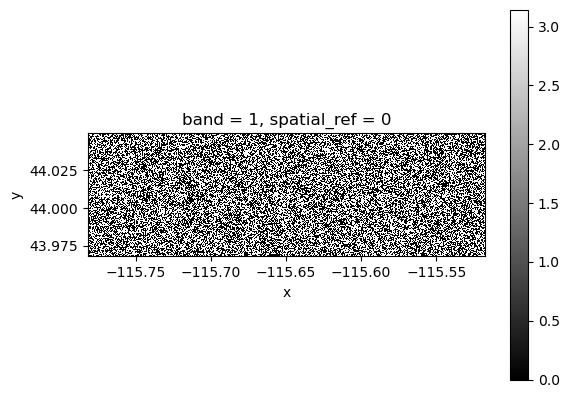

In [12]:
import xarray as xr
data_array = rxa.open_rasterio(data_dir + "lowman_05208_20002_006_200131_L090VV_01_BU_s2_2x8.slc.real.tif", parse_coordinates=True)
# data_array.rio.write_nodata(-9999.0, inplace=True)
print(data_array.min().values)
print(data_array.max().values)

print(data_array.rio.bounds())

# get phase of slc 
phase = data_array.copy(data=np.empty(data_array.shape, dtype=xr.DataArray))
# print(type(phase))
# print(phase.rio.crs)
phase.values = xr.DataArray(np.angle(data_array))

ax = phase.real.plot(cmap='gray')
ax.axes.set_aspect('equal')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Real val of SLC lowman_05208_20002_006_200131")

plt.show()

In [114]:
from scipy.signal import convolve2d
def calc_coherence_unweighted1(img1, img2, window=13) :

    # create window over which to do the magnitude calculation 
    kernel = np.ones((window, window), dtype=np.float32)
    kernel /= kernel.sum()

    if (type(img1) == xr.DataArray) or (type(img2) == xr.DataArray) :
        img1_arr = img1.values[0,:,:]
        img2_arr = img2.values[0,:,:]
        out_arr = img1.copy(data=np.empty(img1.shape, dtype=np.complex64))
    else :
        img1_arr = img1
        img2_arr = img2

    # Numerator: E[u1 * conj(u2)] a.k.a. the cross product of the two complex numbers
    cross_prod = img1_arr * np.conj(img2_arr)

    print(type(cross_prod))
    print((cross_prod.real.shape))

    # convolve2d does the leg work of moving the window over all pixels. 
    # the 'symm' boundary creates a mirror reflection to fill in areas for pixels at the edges
    num_real = convolve2d(cross_prod.real, kernel, mode='same', boundary='symm')
    num_imag = convolve2d(cross_prod.imag, kernel, mode='same', boundary='symm')
    # put the separate components back together 
    numerator = num_real + 1j * num_imag

    # Denominator: sqrt(E[|u1|^2] * E[|u2|^2])
    power1 = convolve2d(np.abs(img1_arr)**2, kernel, mode='same', boundary='symm')
    power2 = convolve2d(np.abs(img2_arr)**2, kernel, mode='same', boundary='symm')
    denom = np.sqrt(power1 * power2)
    denom[denom == 0] = 1e-12  # Prevent divide by zero

    # Coherence magnitude
    coherence = np.abs(numerator / denom)

    if (type(img1) == xr.DataArray) or (type(img2) == xr.DataArray) :
        out_arr.values = coherence.reshape(img1.shape)
    else :
        out_arr = coherence
    return out_arr

In [115]:
print(phase.rio.bounds())
real = rxa.open_rasterio("../data/snowex_lowman/slcs_geocoded/lowman_05208_20002_006_200131_L090VV_01_BU_s2_2x8.slc.real.tif", parse_coordinates=True)
print(real.rio.bounds())

slc1 = rxa.open_rasterio(data_dir + "lowman_05208_20002_006_200131_L090VV_01_BU_s2_2x8.slc.tif", parse_coordinates=True)
slc2 = rxa.open_rasterio(data_dir + "lowman_05208_20007_002_200213_L090VV_01_BU_s2_2x8.slc.tif", parse_coordinates=True)

print(type(slc1))

coh12 = calc_coherence_unweighted1(slc1, slc2)


(-115.78172422468924, 43.96779286703164, -115.51764754468925, 44.04996610703165)
(-115.78172422468924, 43.96779286703164, -115.51764754468925, 44.04996610703165)
<class 'xarray.core.dataarray.DataArray'>
<class 'numpy.ndarray'>
(1479, 4753)


<class 'xarray.core.dataarray.DataArray'>


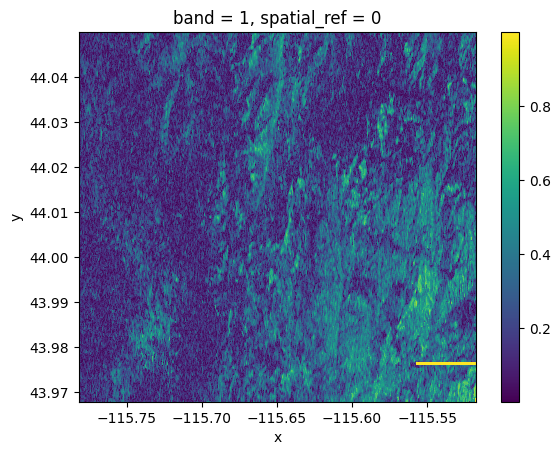

In [117]:
print(type(coh12))
coh12.plot()
# coh.rio.to_raster(data_dir + "coherence_lowman_52.tif")

/Users/julo9057/anaconda3/envs/snowex_uavsar_coherence/lib/python3.13/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/julo9057/anaconda3/envs/snowex_uavsar_coherence/lib/python3.13/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/julo9057/anaconda3/envs/snowex_uavsar_coherence/lib/python3.13/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


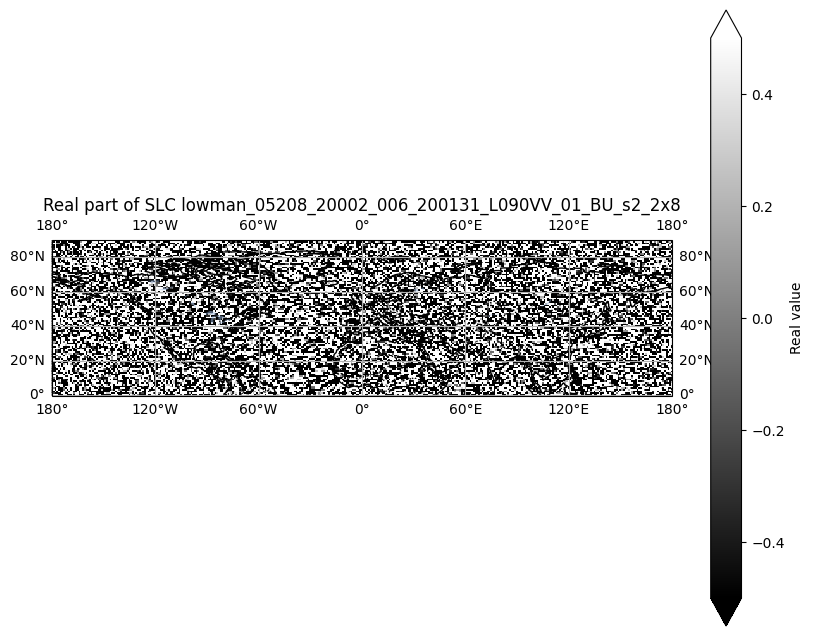

In [ ]:
# Plotting with basemap 

import cartopy as ccrs

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.crs.PlateCarree()) # Or other suitable projection
phase.plot(ax=ax, transform=ccrs.crs.PlateCarree(), vmin=-0.5, vmax=0.5, cmap='gray', cbar_kwargs={'label': 'Real value'})
ax.coastlines()
ax.add_feature(ccrs.feature.BORDERS, linestyle=':')
ax.add_feature(ccrs.feature.LAKES, alpha=0.5)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.set_title('Phase of SLC lowman_05208_20002_006_200131_L090VV_01_BU_s2_2x8')
plt.show()